In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
import random
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

In [2]:
# 데이터셋 및 모델 로드
df = pd.read_csv('test_data_set_food.csv')
model_names = ['egg', 'chicken', 'shrimp', 'cheese', 'pork', 'crab', 'cream', 'tofu', 'lobster', 'peanut', 'bread']

# 이미지 경로 설정
df['image_path'] = df.apply(lambda row: os.path.join('food_dataset/images', row['food_class'], 'png', row['image_name']), axis=1)

# 이미지 전처리 함수
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# 모델 로드 함수
def load_model(model_path, n_labels=1):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, n_labels)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# 예측 함수
def predict_with_model(model, image, multi_label=False):
    with torch.no_grad():
        outputs = model(image)
        if multi_label:
            predictions = torch.sigmoid(outputs).squeeze().numpy()
            return np.round(predictions).astype(int).tolist()
        else:
            prediction = torch.sigmoid(outputs).item()
            return round(prediction)
        
# recall 계산 함수
def calculate_recall(preds, labels):
    preds = np.array(preds)  # 리스트를 numpy 배열로 변환
    labels = np.array(labels)
    return recall_score(labels, preds, zero_division=0, average='macro')

In [3]:
# 개별 모델 및 멀티라벨 모델의 재현율 계산
individual_recalls = []
multi_label_recalls = []

loaded_models = {name: load_model(f'model/new_{name}_model.pth') for name in model_names}
multi_model = load_model('model/new_multi_label_model.pth', n_labels=len(model_names))

# 재현율 계산
for _, row in df.iterrows():
    image_path = row['image_path']
    image = preprocess_image(image_path)
    
    individual_preds = [predict_with_model(loaded_models[name], image) for name in model_names]
    multi_preds = predict_with_model(multi_model, image, multi_label=True)

    actual_labels = row[model_names].tolist()
    
    individual_recall = calculate_recall(actual_labels, individual_preds)
    multi_label_recall = calculate_recall(actual_labels, multi_preds)
    
    individual_recalls.append(individual_recall)
    multi_label_recalls.append(multi_label_recall)

In [4]:
# 평균 재현율
average_individual_recall = np.mean(individual_recalls)
average_multi_label_recall = np.mean(multi_label_recalls)

print(f"Average Individual Model Recall: {average_individual_recall}")
print(f"Average Multi Label Model Recall: {average_multi_label_recall}")

Average Individual Model Recall: 0.6916562596229513
Average Multi Label Model Recall: 0.8052787947217755


Image Path: food_dataset/images\korean_pancake\png\korean_pancake_0798.png
Image Name: korean_pancake_0798.png
Individual Model Predictions (Positive):
['peanut']
Multi Label Model Predictions (Positive):
[]
Actual Labels (Positive):
[]


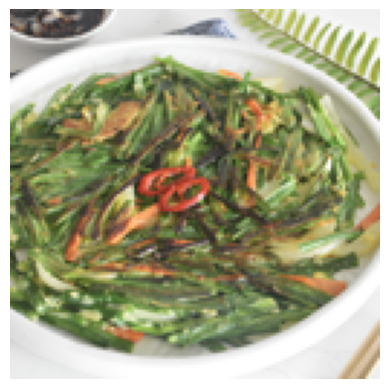

In [6]:
# 테스트 데이터셋에서 무작위 이미지 선택
random_row = df.sample(1).iloc[0]
image_path = random_row['image_path']
image_name = random_row['image_name']
actual_labels = random_row[model_names].tolist()

# 이미지 전처리
image = preprocess_image(image_path)

# 개별 모델 및 멀티라벨 모델 예측
individual_preds = [predict_with_model(loaded_models[name], image) for name in model_names]
multi_preds = predict_with_model(multi_model, image, multi_label=True)

# 결과 출력
print(f"Image Path: {image_path}")
print(f"Image Name: {image_name}")
print("Individual Model Predictions (Positive):")
print([name for pred, name in zip(individual_preds, model_names) if pred == 1])
print("Multi Label Model Predictions (Positive):")
print([name for pred, name in zip(multi_preds, model_names) if pred == 1])
print("Actual Labels (Positive):")
print([name for label, name in zip(actual_labels, model_names) if label == 1])

# print(f"Individual Model Predictions: {individual_preds}")
# print(f"Multi Label Model Predictions: {multi_preds}")
# print(f"Actual Labels: {actual_labels}")

# 이미지 표시
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()